In [1]:
from pathlib import Path

from scipy import stats
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from shapely.geometry import MultiPoint, Point, Polygon
from shapely.ops import split, snap, nearest_points

### Paths

In [2]:
data_path = Path('../data')
sentinel_path = data_path/'sentinel'
output_path = Path('output')
shape_path = Path('output/shapes')
patch_path = Path('output/patches')
feature_path = Path('output/features')

feature_path.mkdir(exist_ok=True, parents=True)
shape_path.mkdir(exist_ok=True, parents=True)

### Create statistics from imagery features

In [3]:
def calculate_stats(data, aggs, aggregation_axis=0, stacking_axis=-1):
    stats_list = []
    for agg in aggs:
        stats_list.append(agg(data, axis=aggregation_axis))
    
    return np.stack(stats_list, axis=stacking_axis)
        

In [63]:
aggs = [np.mean,    
        np.min,
        np.max,
        np.median,
        np.std]

field_ids              = []

features_stats         = []
composite_max_ndvi     = []
composite_min_ndvi     = []
composite_max_ndvi_lbp = []
composite_min_ndvi_lbp = []
composite_max_ndvi_hog = []
composite_min_ndvi_hog = []

argmax_b4              = []
argmin_b4              = []
argmax_ndvi            = []
argmin_ndvi            = []
argmax_ndvi_slope      = []
argmin_ndvi_slope      = []
stf                    = []

for i in range(12):
    patch = EOPatch.load(feature_path/f'eopatch_{i}')

    field_id_mask = (patch.mask_timeless['FIELD_ID'] > 0).squeeze()
    
    field_ids              .append(patch.mask_timeless['FIELD_ID'][field_id_mask].squeeze())
    
    features_stats         .append(calculate_stats(patch.data['FEATURES'],aggs=aggs)[field_id_mask,...])                 #(5, 1345, 1328, 6)
    composite_max_ndvi     .append(patch.data['COMPOSITE_MAX_NDVI'][0,field_id_mask,:])                                  #(1, 1345, 1328, 6)
    composite_min_ndvi     .append(patch.data['COMPOSITE_MIN_NDVI'][0,field_id_mask,:])                                  #(1, 1345, 1328, 6)
    composite_max_ndvi_lbp .append(patch.data['COMPOSITE_MAX_NDVI_LBP'][0,field_id_mask,:])                              #(1, 1345, 1328, 6)
    composite_min_ndvi_lbp .append(patch.data['COMPOSITE_MIN_NDVI_LBP'][0,field_id_mask,:])                              #(1, 1345, 1328, 6)
    composite_max_ndvi_hog .append(patch.data['COMPOSITE_MAX_NDVI_HOG'][0,field_id_mask,:])                              #(1, 1345, 1328, 9)
    composite_min_ndvi_hog .append(patch.data['COMPOSITE_MIN_NDVI_HOG'][0,field_id_mask,:])                              #(1, 1345, 1328, 9)
                                   
    argmax_b4              .append(patch.data_timeless['ARGMAX_B4'][field_id_mask,:])                                    #(1345, 1328, 1)
    argmin_b4              .append(patch.data_timeless['ARGMIN_B4'][field_id_mask,:])                                    #(1345, 1328, 1)
    argmax_ndvi            .append(patch.data_timeless['ARGMAX_NDVI'][field_id_mask,:])                                  #(1345, 1328, 1)
    argmin_ndvi            .append(patch.data_timeless['ARGMIN_NDVI'][field_id_mask,:])                                  #(1345, 1328, 1)
    argmax_ndvi_slope      .append(patch.data_timeless['ARGMAX_NDVI_SLOPE'][field_id_mask,:])                            #(1345, 1328, 1)
    argmin_ndvi_slope      .append(patch.data_timeless['ARGMIN_NDVI_SLOPE'][field_id_mask,:])                            #(1345, 1328, 1)
    stf                    .append(patch.data_timeless['STF'][field_id_mask,:])                                          #(1345, 1328, 20)

In [64]:
field_ids_arr              = np.concatenate(field_ids              , axis = 0)

features_stats_arr         = np.concatenate(features_stats         , axis = 0)

composite_max_ndvi_arr     = np.concatenate(composite_max_ndvi     , axis = 0)
composite_min_ndvi_arr     = np.concatenate(composite_min_ndvi     , axis = 0)
composite_max_ndvi_lbp_arr = np.concatenate(composite_max_ndvi_lbp , axis = 0)
composite_min_ndvi_lbp_arr = np.concatenate(composite_min_ndvi_lbp , axis = 0)
composite_max_ndvi_hog_arr = np.concatenate(composite_max_ndvi_hog , axis = 0)
composite_min_ndvi_hog_arr = np.concatenate(composite_min_ndvi_hog , axis = 0)

argmax_b4_arr              = np.concatenate(argmax_b4              , axis = 0)
argmin_b4_arr              = np.concatenate(argmin_b4              , axis = 0)
argmax_ndvi_arr            = np.concatenate(argmax_ndvi            , axis = 0)
argmin_ndvi_arr            = np.concatenate(argmin_ndvi            , axis = 0)
argmax_ndvi_slope_arr      = np.concatenate(argmax_ndvi_slope      , axis = 0)
argmin_ndvi_slope_arr      = np.concatenate(argmin_ndvi_slope      , axis = 0)

stf_arr                    = np.concatenate(stf                    , axis = 0)

In [81]:
red_arr   = features_stats_arr[:,0,:]
green_arr = features_stats_arr[:,1,:]
blue_arr  = features_stats_arr[:,2,:]
nir_arr   = features_stats_arr[:,3,:]
ndvi_arr  = features_stats_arr[:,4,:]
norm_arr  = features_stats_arr[:,5,:]

In [105]:
def mode(a, axis=0):
    return stats.mode(a,axis=axis)[0][0]

In [106]:
arr_list = [
    ('red_t_med'              , red_arr                    , [np.median]),
    ('green_t_med'            , green_arr                  , [np.median]),
    ('blue_t_med'             , blue_arr                   , [np.median]),
    ('nir_t_med'              , nir_arr                    , [np.median]),
    ('ndvi_t_med'             , ndvi_arr                   , [np.median]),
    ('norm_t_med'             , norm_arr                   , [np.median]),
    ('composite_max_ndvi'     , composite_max_ndvi_arr     , aggs),
    ('composite_min_ndvi'     , composite_min_ndvi_arr     , aggs),
    ('composite_max_ndvi_lbp' , composite_max_ndvi_lbp_arr , aggs),
    ('composite_min_ndvi_lbp' , composite_min_ndvi_lbp_arr , aggs),
    ('composite_max_ndvi_hog' , composite_max_ndvi_hog_arr , aggs),
    ('composite_min_ndvi_hog' , composite_min_ndvi_hog_arr , aggs),
    ('argmax_b4'              , argmax_b4_arr              , [mode]),
    ('argmin_b4'              , argmin_b4_arr              , [mode]),
    ('argmax_ndvi'            , argmax_ndvi_arr            , [mode]),
    ('argmin_ndvi'            , argmin_ndvi_arr            , [mode]),
    ('argmax_ndvi_slope'      , argmax_ndvi_slope_arr      , [mode]),
    ('argmin_ndvi_slope'      , argmin_ndvi_slope_arr      , [mode]),
    ('stf_arr'                , stf_arr                    , aggs)]

### Create dataset with statistics for each field 

In [120]:
rows = []

for fid in train_test_gpdf.Field_Id:
    fid_mask = field_ids_arr==fid
    fid_dic = {'Field_Id': fid}
    for name, arr, funcs in arr_list:
        for i in range(arr.shape[-1]):
            for f in funcs:
                fid_dic[f'{name}_{f.__name__}_{i}'] = f(arr[fid_mask,i],axis=0)
    
    rows.append(fid_dic)

### Save stats to disk

In [121]:
poly_img_stats_df = pd.DataFrame(rows)
poly_img_stats_df.to_csv(data_path/'polygon_img_statistics.csv', index=False)

### Read in polygon image statistics

In [3]:
poly_img_stats_df = pd.read_csv(data_path/'polygon_img_statistics.csv')

#### Read in train and test shape file and csv file

In [4]:
train_test_shp = gpd.read_file(data_path/'train_test_shp')

### Add shape and river features

In [17]:
orange_river_segment_shp = gpd.read_file('../data/orange_river_segment/'
                                        ).to_crs({'init': 'epsg:32734'})

In [19]:
train_shp = gpd.read_file(data_path/'train').dropna().to_crs({'init': 'epsg:32734'})
test_shp = gpd.read_file(data_path/'test').to_crs({'init': 'epsg:32734'})

([], <a list of 0 Text yticklabel objects>)

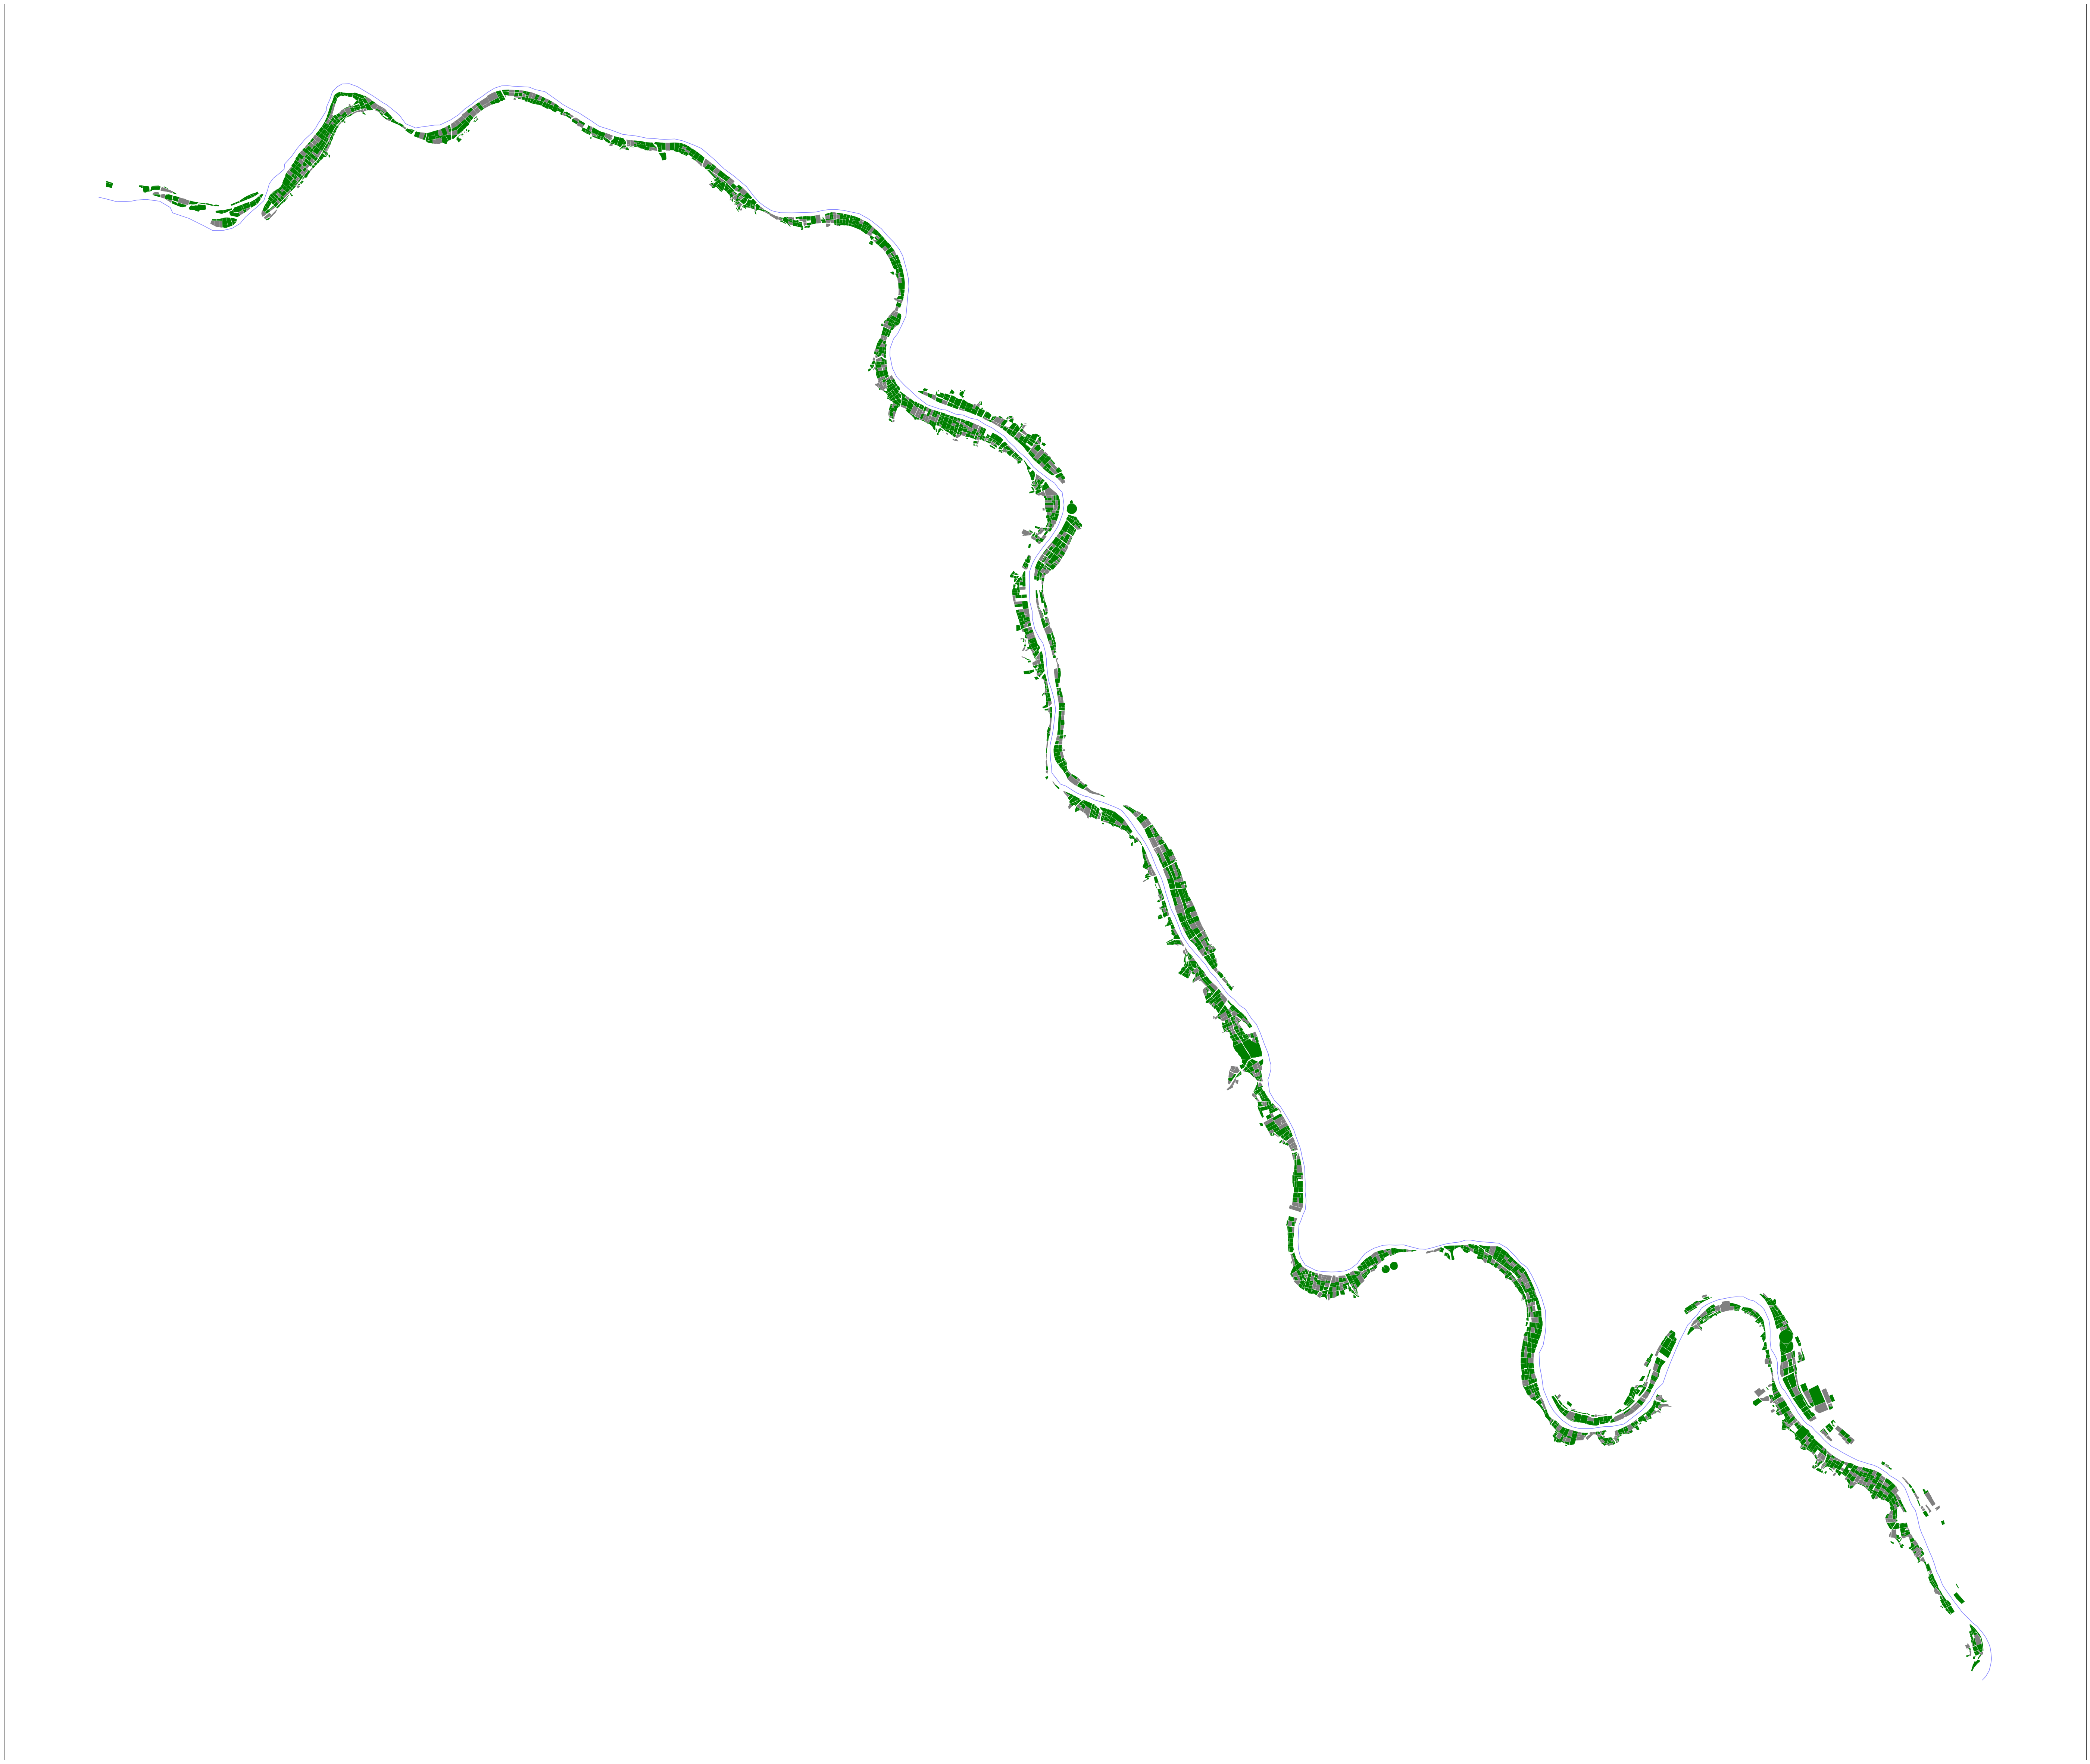

In [29]:
ax = test_shp.plot(figsize=(100,100), color = 'grey')
train_shp.plot(figsize=(100,100), color = 'green', ax=ax)
orange_river_segment_shp.plot(ax=ax, color = 'blue', alpha =0.5)
plt.xticks([])
plt.yticks([])

In [7]:
def nearest_neighbor_within(others, point, max_distance):
    """Find nearest point among others up to a maximum distance.
    
    Args:
        others: a list of Points or a MultiPoint
        point: a Point
        max_distance: maximum distance to search for the nearest neighbor
        
    Returns:
        A shapely Point if one is within max_distance, None otherwise
    """
    search_region = point.buffer(max_distance)
    interesting_points = search_region.intersection(MultiPoint(others))
    
    if not interesting_points:
        closest_point = None
    elif isinstance(interesting_points, Point):
        closest_point = interesting_points
    else:            
        distances = [point.distance(ip) for ip in interesting_points
                     if point.distance(ip) > 0]
        closest_point = interesting_points[distances.index(min(distances))]
    
    return closest_point

def get_distance_along_line(gdf_line, poly, tolerance=10000):
    # union all geometries
    line = gdf_line.geometry.unary_union
    
    point = poly.centroid

    split_line = split(line, nearest_neighbor_within(line.coords,point,tolerance))
    
    return split_line[0].length

def get_distance_from_line(gdf_line, poly, tolerance=10000):
    # union all geometries
    line = gdf_line.geometry.unary_union
    
    point = poly.centroid
    
    return point.distance(nearest_neighbor_within(line.coords,point,tolerance))

def get_side_of_line(gdf_line, poly, tolerance=10000):
    # union all geometries
    line = gdf_line.geometry.unary_union
    
    point = poly.centroid
    
    nearest_point = nearest_neighbor_within(line.coords,point,tolerance)
    
    if (nearest_point.coords.xy[0] < point.coords.xy[0] 
        and nearest_point.coords.xy[1] < point.coords.xy[1]):
        return 'NE'
    else:
        return 'SW'
    
    return point.distance()

In [8]:
train_test_shp['distance_along_river'] = train_test_shp.geometry.apply(
    lambda x: get_distance_along_line(orange_river_segment_shp, x))

In [9]:
train_test_shp['distance_from_river'] = train_test_shp.geometry.apply(
    lambda x: get_distance_from_line(orange_river_segment_shp, x))

In [10]:
train_test_shp['side_of_river'] = train_test_shp.geometry.apply(
    lambda x: get_side_of_line(orange_river_segment_shp, x))

In [11]:
train_test_shp['centroid_x'] = train_test_shp.geometry.apply(lambda x: x.centroid.coords.xy[0][0])
train_test_shp['centroid_y'] = train_test_shp.geometry.apply(lambda x: x.centroid.coords.xy[1][0])

In [12]:
train_test_shp['corner_count'] = train_test_shp.geometry.apply(lambda x: len(x.boundary.coords))

In [13]:
train_test_shp['squareness'] = train_test_shp.geometry.apply(lambda x: (x.area**.5)/(x.boundary.length/4))

### Count number of each crop in a radius around polygon

In [14]:
def count_nearby_crops(row):
    search_region = row.geometry.buffer(300)
    crop_list = []
    
    for i, r in train_test_shp.iterrows():
        if row.Field_Id != r.Field_Id and r.geometry.within(search_region):
            crop_list.append(r.Crop_Id_Ne)

    crop_counts = {}
    crops = ['1', '2', '3', '4', '5', '6', '7', '8', '9']
    for crop in crops:
        crop_counts[f'nearby_crop_{crop}_count'] = crop_list.count(crop)
        
    crop_counts['total_nearby_crop_count']  = sum([c for c in crop_counts.values() if c!='-1'])
    
    for crop in crops:
        crop_counts[f'nearby_crop_{crop}_prop'] = crop_counts[f'nearby_crop_{crop}_count']/max(crop_counts['total_nearby_crop_count'],1)
    
    crop_counts['total_nearby_field_count'] = len(crop_list)
    crop_counts['Field_Id'] = row.Field_Id
    return crop_counts

In [28]:
from joblib import Parallel, delayed
from tqdm import tqdm

def apply_count_nearby_crops(df):
    return list(df.apply(count_nearby_crops,axis=1))

bs = 223
dfs = [train_test_shp.iloc[i*bs:min((i+1)*bs,len(train_test_shp))] for i in range(len(train_test_shp)//bs)]

In [30]:
lists = Parallel(n_jobs=-1)(delayed(apply_count_nearby_crops)(df) for df in dfs)

In [31]:
crop_count_df = pd.concat([pd.DataFrame(l) for l in lists])

In [32]:
crop_count_df.to_csv(data_path/'nearby_crop_count.csv', index=False)

In [33]:
shape_features = train_test_shp.merge(crop_count_df, how='left', on='Field_Id')

### Join with polygon image stats

In [38]:
shape_and_img_features = shape_features.merge(poly_img_stats_df, how='left', on='Field_Id')

In [39]:
shape_and_img_features.to_csv(data_path/'features.csv', index=False)

In [41]:
shape_and_img_features.shape

(3568, 380)